In [ ]:
#@title ① ライブラリのインストール

# ================================
# セル 1 : install dependencies
# ================================
!pip -q install --upgrade --no-cache-dir --force-reinstall \
    numpy==1.26.4 \
    pillow==10.3.0 \
    torch==2.3.0+cu121 torchvision==0.18.0+cu121 \
        -f https://download.pytorch.org/whl/torch_stable.html \
    diffusers==0.32.0 transformers==4.40.0 accelerate peft==0.10.0 \
    facenet-pytorch lpips safetensors onnxruntime protobuf==3.20.3 \
    opencv-python-headless==4.9.0.80 mediapipe==0.10.9

print("✅ install finished – OpenCV headless & mediapipe ready")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.0/781.0 MB 291.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 324.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 212.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 247.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 254.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 291.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 297.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 246.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 114.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 219.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title ② 設定

# ================================
# セル 2 : common imports & paths
# ================================

# --- Pillow バージョン強制チェック -----------------
import importlib, subprocess, sys
try:
    import PIL, pkg_resources
    ver = tuple(map(int, PIL.__version__.split(".")[:2]))
    if ver < (10, 0):
        print("⚠️  Old Pillow detected:", PIL.__version__, "→ upgrading…")
        subprocess.run(
            ["pip", "install", "-q", "--upgrade", "--no-cache-dir",
             "--force-reinstall", "pillow>=10.3.0"],
            check=True,
        )
        importlib.reload(importlib.import_module("PIL"))
        print("✅ Pillow reloaded:", PIL.__version__)
except ModuleNotFoundError:
    subprocess.run(
        ["pip", "install", "-q", "pillow>=10.3.0"],
        check=True,
    )
    import PIL
    print("✅ Pillow installed:", PIL.__version__)
# --------------------------------------------------

from pathlib import Path
import torch, json, ast, random
import pandas as pd
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

DATA_ROOT   = Path("/content/drive/MyDrive/AffectNet")  # ← 適宜変更
CSV_TRAIN   = DATA_ROOT / "train_pairs.csv"
CSV_VAL     = DATA_ROOT / "test_pairs.csv"

PRETRAINED_SD    = "stabilityai/stable-diffusion-2-1-base"
CONTROLNET_FACE  = "CrucibleAI/ControlNetMediaPipeFace"

IMG_SIZE    = 96
BATCH_SIZE  = 32
LR          = 1e-4
MAX_STEPS   = 10000
SAVE_EVERY  = 1000
λ_id, λ_au, λ_perc, λ_noise = 0.5, 1.0, 0.1, 0.1
# λ_id, λ_au, λ_perc, λ_noise = 0, 0, 0, 0.1


In [ ]:
#@title ③ データロード

# ================================
# セル 3 : dataset / dataloader
# ================================
class AffectDataset(Dataset):
    def __init__(self, csv_path):
        df = pd.read_csv(csv_path)
        self.paths = df["image_path"].tolist()
        self.au    = df["au_vector"].apply(eval).tolist()
        self.tf = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3),
        ])
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        x   = self.tf(img)
        y   = torch.tensor(self.au[idx], dtype=torch.float32)
        return {"pixel_values": x, "au_target": y}

train_dl = DataLoader(
    AffectDataset(CSV_TRAIN),
    batch_size=BATCH_SIZE, shuffle=True,
    num_workers=2, pin_memory=True
)

val_ds = AffectDataset(CSV_VAL)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=False,
                    num_workers=2, pin_memory=True)

print(f"✅ val_ds ready: {len(val_ds)} images")
print(f"✅ dataloader ready: {len(train_dl.dataset)} images")


✅ val_ds ready: 8733 images
✅ dataloader ready: 11183 images


In [ ]:
#@title ④ AU CNN 読み込み

# ================================
# セル 4 : load distilled AU net
# ================================
AU_CKPT = "/content/drive/MyDrive/AU_distill/resnet18_au.pth"

from torchvision.models import resnet18
au_net = resnet18(weights=None)
au_net.fc = torch.nn.Sequential(torch.nn.Linear(512, 35), torch.nn.Sigmoid())
au_net.load_state_dict(torch.load(AU_CKPT, map_location="cpu"))
print("✅ distilled AU net loaded")


✅ distilled AU net loaded


In [ ]:
#@title ⑤ モデル準備

# ======================================================
# ⑤ モデル準備  ― AU‑token 用 “空プロンプト” を用意
# ======================================================
import torch, torch.nn as nn, warnings, numpy as np
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from peft        import LoraConfig, get_peft_model
from accelerate  import Accelerator
from facenet_pytorch import InceptionResnetV1
import lpips

# --------------------------------------------
# 0. diffusers が参照する “未定義 dtype” をダミー登録
# --------------------------------------------
_missing = {
    "uint1": torch.uint8, "uint2": torch.uint8, "uint4": torch.uint8,
    "float8_e5m2": torch.float16, "float8_e4m3fn": torch.float16,
    "bfloat8": torch.float16,
}
for k, v in _missing.items():
    if not hasattr(torch, k):
        setattr(torch, k, v)

# --------------------------------------------
# 1.  SD + ControlNet パイプライン（fp32 で読み込み）
# --------------------------------------------
controlnet = ControlNetModel.from_pretrained(
    CONTROLNET_FACE, torch_dtype=torch.float32
)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    PRETRAINED_SD,
    controlnet     = controlnet,
    safety_checker = None,
    torch_dtype    = torch.float32,
)

# --------------------------------------------
# 2.  LoRA を差し込み
# --------------------------------------------
lora_cfg = LoraConfig(
    r=16, lora_alpha=16,
    target_modules=["to_k", "to_q", "to_v", "to_out.0"],
)
pipe.unet = get_peft_model(pipe.unet, lora_cfg)

# --------------------------------------------
# 3.  “空プロンプト(\"\")” の CLIP 埋め込みを作成
#     ↳ CPU / fp32 で一度だけ計算し、pipe.empty_emb に保存
# --------------------------------------------
# ─── 3.  “空プロンプト(\"\")” の CLIP 埋め込みを作成 ──────────────
from transformers import CLIPTokenizer, CLIPTextModel

try:
    # ❶ tokenizer / ❷ text‑encoder ともに subfolder を明示
    tokenizer    = CLIPTokenizer.from_pretrained(PRETRAINED_SD, subfolder="tokenizer")
    text_encoder = CLIPTextModel .from_pretrained(PRETRAINED_SD, subfolder="text_encoder")
except OSError as e:                           # v1 系などはサブフォルダ無し
    warnings.warn(f"{e}\n→ fallback: root dir loading (SD‑v1.x?)")
    tokenizer    = CLIPTokenizer.from_pretrained(PRETRAINED_SD)
    text_encoder = CLIPTextModel .from_pretrained(PRETRAINED_SD)

with torch.no_grad():
    tok = tokenizer(
        [""], padding="max_length", max_length=77, return_tensors="pt"
    ).input_ids
    empty_emb = text_encoder(tok)[0].detach().cpu()   # (1,77,D) fp32

pipe.empty_emb = empty_emb          # 学習 / 推論セルで利用
print("✅ empty_emb registered:", tuple(pipe.empty_emb.shape))

# --------------------------------------------
# 4.  AU → token 線形層
# --------------------------------------------
cross_dim = pipe.unet.config.cross_attention_dim  # v1=768, v2=1024, XL=1280...
au_proj   = nn.Linear(35, cross_dim)

# --------------------------------------------
# 5.  評価ネット & 損失
# --------------------------------------------
arcface    = InceptionResnetV1(pretrained="vggface2").eval()
lpips_loss = lpips.LPIPS(net="vgg").eval()

# ↓ ここでは “au_net” が既に別セルで定義／学習済みである前提
openface_au_model = au_net.eval()

# --------------------------------------------
# 6.  Accelerator でまとめて GPU 配置
#     text_encoder はもう使わないので渡さない
# --------------------------------------------
accelerator = Accelerator()
(
    pipe,
    au_proj,
    arcface,
    openface_au_model,
    lpips_loss,
) = accelerator.prepare(
    pipe,
    au_proj,
    arcface,
    openface_au_model,
    lpips_loss,
)

# VAE は勾配不要・fp32 固定
pipe.vae.requires_grad_(False)
pipe.vae.to(accelerator.device, dtype=torch.float32).eval()

print("✅ Model prep finished — device:", accelerator.device)
# pipe.empty_emb は CPU/fp32 のまま保持 → 学習／推論セルで
# `pipe.empty_emb.to(accelerator.device)` として使ってください


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

✅ empty_emb registered: (1, 77, 1024)
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth
✅ Model prep finished — device: cuda


In [ ]:
#@title ⑥ 追加学習

# ================================
# セル 6 : training loop
# ================================
from tqdm.auto import tqdm
from diffusers import DDPMScheduler
import torch.nn.functional as F

# ★★★ 追加：必ず VAE / UNet / ControlNet を学習デバイスへ固定 ★★★
pipe.vae       .to(accelerator.device, dtype=torch.float32)
pipe.unet      .to(accelerator.device, dtype=torch.float32)
pipe.controlnet.to(accelerator.device, dtype=torch.float32)
# --------------------------------------------------------------------------------

noise_scheduler = DDPMScheduler(num_train_timesteps=1000,
                                beta_start=1e-4, beta_end=0.02)

optim = torch.optim.AdamW(
    list(pipe.unet.parameters()) + list(au_proj.parameters()),
    lr=LR, weight_decay=1e-2
)

global_step = 0
pbar = tqdm(total=MAX_STEPS)

while global_step < MAX_STEPS:
    for batch in train_dl:
        imgs = batch["pixel_values"].to(accelerator.device, torch.float32)
        aus  = batch["au_target"]  .to(accelerator.device, torch.float32)

        # ----- latent + noise ---------------------------------
        with torch.no_grad():
            latents = pipe.vae.encode(imgs * 0.18215).latent_dist.sample()
        latents = latents * 0.18215
        noise   = torch.randn_like(latents)
        t       = torch.randint(
            0, 1000, (latents.size(0),),
            device=latents.device, dtype=torch.long
        )
        noisy_lat = noise_scheduler.add_noise(latents, noise, t)

        # ----- AU + 空プロンプト token 連結 --------------------
        au_tok  = au_proj(aus).unsqueeze(1)               # (B,1,D)
        txt_tok = pipe.empty_emb.to(accelerator.device)   # (1,77,D)
        txt_tok = txt_tok.expand(imgs.size(0), -1, -1)    # (B,77,D)
        enc_hid = torch.cat([txt_tok, au_tok], dim=1)     # (B,78,D)

        # ----- diffusion forward ------------------------------
        noise_pred = pipe.unet(noisy_lat, t,
                               encoder_hidden_states=enc_hid)["sample"]
        L_noise = F.mse_loss(noise_pred, noise)

        # ----- decode & extra losses --------------------------
        with torch.no_grad():
            pred_clean_latent = noise_scheduler.step(
                model_output = noise_pred,       # ε
                timestep     = t,
                sample       = noisy_lat         # x_t
            ).pred_original_sample              # x₀ (形状＝latent と同じ)

            img_out = pipe.decode_latents((noise_pred / 0.18215).float())
        img_out = (torch.from_numpy(img_out)
                         .permute(0,3,1,2)
                         .to(accelerator.device, torch.float32))

        L_img  = F.l1_loss(img_out, imgs)

        id_src = arcface(F.interpolate(imgs    , (112,112)))
        id_out = arcface(F.interpolate(img_out , (112,112)))
        L_id   = 1 - F.cosine_similarity(id_src, id_out).mean()

        au_pred = openface_au_model(img_out)
        L_au    = F.l1_loss(au_pred, aus)

        L_perc  = lpips_loss(img_out, imgs).mean()

        # ----- back‑prop --------------------------------------
        loss = 0.1 * L_noise + λ_id*L_id + λ_au*L_au + λ_perc*L_perc
        accelerator.backward(loss)
        optim.step(); optim.zero_grad()

        global_step += 1
        pbar.update(1)
        if accelerator.is_main_process and global_step % 50 == 0:
            pbar.set_postfix(
                loss = f"{loss.item():.3f}",
                noise= f"{L_noise.item():.3f}",
                id   = f"{L_id.item():.3f}",
                au   = f"{L_au.item():.3f}",
                perc = f"{L_perc.item():.3f}",
            )

        if global_step >= MAX_STEPS:
            break

pbar.close()
print("🎉 Training finished on", accelerator.device)


  0%|          | 0/10000 [00:00<?, ?it/s]

🎉 Training finished on cuda


In [ ]:
# セル: ControlNet 用ランドマーク画像生成 -----------------------------
import cv2, numpy as np, mediapipe as mp, torch
from torchvision.transforms.functional import to_tensor

mp_face = mp.solutions.face_mesh.FaceMesh(static_image_mode=True,
                                          refine_landmarks=True)

def control_image_from_face(img: torch.Tensor) -> torch.Tensor:
    """
    img : (B,3,H,W) 0‑1 float / CUDA
    return : (B,3,512,512) 0‑1 float / 同じ device
    """
    imgs = (img * 255).clamp(0, 255).byte().cpu().permute(0, 2, 3, 1).numpy()
    out  = torch.zeros(img.shape[0], 3, 512, 512, dtype=torch.float32)

    for i, bgr in enumerate(imgs[..., ::-1]):  # RGB→BGR
        h0, w0, _ = bgr.shape
        res = mp_face.process(bgr)
        canvas = np.zeros((512, 512, 3), np.uint8)

        if res.multi_face_landmarks:
            lm  = res.multi_face_landmarks[0].landmark
            pts = np.array([[p.x * w0, p.y * h0] for p in lm]).astype(int)

            # 輪郭
            cv2.polylines(canvas, [pts[0:17]], False, (255, 255, 255), 2)
            # 主な特徴点を小さな円で
            for idx in [33, 133, 263, 362, 1, 57, 61, 146, 291]:
                cv2.circle(canvas, pts[idx], 2, (255, 255, 255), -1)

        canvas = cv2.resize(canvas, (512, 512), cv2.INTER_AREA)
        out[i] = to_tensor(canvas)          # (3,512,512) 0‑1

    return out.to(img.device)


/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/controlnet/pipeline_controlnet.py:569: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


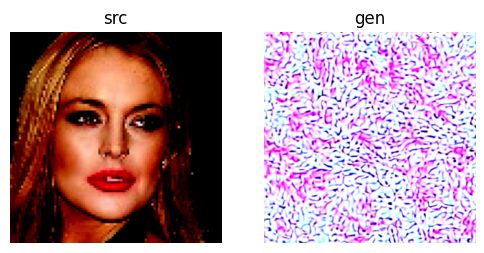

In [ ]:
#@title ⑦ 推論サンプル

# -----------------------------------------------------------
# ⑦ 推論サンプル  –  OOM 回避・超省メモリ版（修正版）
# -----------------------------------------------------------
import torch, random, numpy as np, matplotlib.pyplot as plt
from diffusers import DDPMScheduler
from torch import autocast                       # ← 新 API

# 0) パイプは「CPU + fp32」で保持し、オフロードだけ利用
pipe = pipe.to("cpu", dtype=torch.float32)       # ★ fp32 に戻す
pipe.enable_attention_slicing()
pipe.enable_vae_slicing()
pipe.enable_model_cpu_offload()                  # ← GPU⇔CPU を自動管理
# LoRA / AU 埋め込み線形層だけ fp16 化（GPU に載るとき軽くなる）
au_proj = au_proj.to(dtype=torch.float16)

pipe.unet.eval(); pipe.vae.eval(); pipe.controlnet.eval()

# 1) 15‑step DDPM スケジューラ
scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_start=1e-4, beta_end=0.02
)
scheduler.set_timesteps(15)

# 2) サンプル取得
sample   = val_ds[random.randrange(len(val_ds))]
src_img  = sample["pixel_values"].unsqueeze(0).to("cuda", torch.float16)
tgt_au   = sample["au_target"]  .unsqueeze(0).to("cuda", torch.float16)

with torch.no_grad():
    cnet_lat = control_image_from_face(src_img.float()).half().to("cuda")
    enc_hid  = au_proj(tgt_au).unsqueeze(1)      # (1,1,1024) fp16

# 3) 逆拡散ループ
latents = torch.randn(1,4,64,64, device="cuda", dtype=torch.float16)

with torch.no_grad(), autocast(device_type="cuda", dtype=torch.float16):  # ← 修正
    for t in scheduler.timesteps:
        lat_in = scheduler.scale_model_input(latents, t)

        # 3‑A) ControlNet
        cnet_out = pipe.controlnet(
            lat_in, t,
            encoder_hidden_states = enc_hid,
            controlnet_cond       = cnet_lat,
            guess_mode            = False,
            return_dict           = True,
        )
        down_res = cnet_out.down_block_res_samples       # fp16
        mid_res  = cnet_out.mid_block_res_sample         # fp16

        # 3‑B) UNet
        noise_pred = pipe.unet(
            lat_in, t,
            encoder_hidden_states           = enc_hid,
            down_block_additional_residuals = down_res,
            mid_block_additional_residual   = mid_res,
        )["sample"]

        latents = scheduler.step(noise_pred, t, latents).prev_sample

# 4) デコード & 可視化
with torch.no_grad():
    # decode_latents が fp32 を想定しているのでキャスト
    img_np = pipe.decode_latents((latents / 0.18215).float())[0]   # (H,W,3) NumPy

plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.title("src")
plt.imshow(src_img[0].float().permute(1,2,0).cpu()); plt.axis("off")

plt.subplot(1,2,2); plt.title("gen")
plt.imshow(np.clip(img_np, 0.0, 1.0)); plt.axis("off")
plt.show()


In [ ]:

#@title ⑧ LoRA 重みを書き出し

SAVE_DIR = "/content/drive/MyDrive/lora_final"
pipe.unet.save_pretrained(SAVE_DIR)
print(f"LoRA weights saved to: {SAVE_DIR}")


LoRA weights saved to: /content/drive/MyDrive/lora_final
